List of theoretical Brown Dwarf (BD) cooling models found in literature:

- [AMES-Dusty 2000](https://cds.cern.ch/record/440166/files/0005557.pdf)
- [AMES-Cond 2003](https://www.aanda.org/articles/aa/pdf/2003/17/aa3343.pdf)
- [Saumon & Marley '08 (SM08)](https://arxiv.org/abs/0808.2611)
- [Fernandes + '19](https://arxiv.org/pdf/1906.05626.pdf)
- [ATMO 2020](https://arxiv.org/abs/2003.13717), data can be found  [here](http://perso.ens-lyon.fr/isabelle.baraffe/ATMO2020/)

Apparently there are two families of models: those of the Lyon group and those of the Saumon & Marley group

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.constants import c, R_jup, M_jup, G, GM_jup, sigma_sb, M_sun, L_sun, R_sun
import astropy.units as u
from scipy.interpolate import interp1d, interp2d
import cmocean
from scipy.stats import loguniform
import sys
sys.path.append("../python/")
from utils import temperature, heat, temperature_withDM
import bokeh.palettes
import _corner
import imp
imp.reload(_corner)
from _corner import corner
import pickle
from scipy.stats import gaussian_kde
import glob

from matplotlib import rc
rc('font', family='times new roman', size=22.)

### Saumon & Marley '08 (fig 2)

In [2]:
age  = {}
logL = {}
L    = {}
M    = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
Teff = {}

evolution_SM08 = {}

for mass in M:
    data = np.genfromtxt("../data/evolution_models/SM08/saumon_marley_fig2_" + str(mass) + ".dat", unpack=True)
    age[mass]  = data[0]
    logL[mass] = data[1]
    L[mass]    = np.power(10, data[1])*L_sun
    Teff[mass] = temperature(L[mass], R_jup)
    
    evolution_SM08[mass] = [10**data[0], Teff[mass], data[1]]
    
    
log_age  = np.linspace(6.1, 9.9, 10)
_log_age = []
_mass    = []
_teff    = []

for m in M:
    Teff_interp = interp1d(age[m], Teff[m])
    for lage in log_age:
        _log_age.append(lage)
        _mass.append(m)
        _teff.append(Teff_interp(lage))

Teff_interp_2d = interp2d(_log_age, _mass, _teff)
_teff = np.asarray(_teff)

191.9765782571303 9198.842056939638


Text(0.5, 0, 'log(age) [yr]')

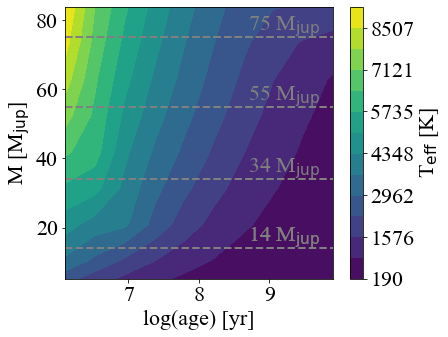

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

Z = _teff.reshape(len(M), len(log_age))

M_in_jup = M*M_sun/M_jup

X, Y = np.meshgrid(log_age, M_in_jup)

#levels = np.linspace(np.min(_teff), np.max(_teff), 14)
levels = np.linspace(190, 9200, 14)
print(np.min(_teff), np.max(_teff))

cs = ax.contourf(X, Y, Z, levels=levels)
cbar = fig.colorbar(cs)
cbar.set_label(r"T$_{\rm eff}$ [K]")
ax.axhline(14, color="grey", ls="--", lw=2.)
ax.text(8.7, 77, r"75 M$_{\rm jup}$", color="grey")
ax.text(8.7, 16, r"14 M$_{\rm jup}$", color="grey")
ax.axhline(75, color="grey", ls="--", lw=2.)

ax.text(8.7, 16, r"14 M$_{\rm jup}$", color="grey")
ax.axhline(75, color="grey", ls="--", lw=2.)
ax.text(8.7, 36, r"34 M$_{\rm jup}$", color="grey")
ax.axhline(34, color="grey", ls="--", lw=2.)
ax.text(8.7, 57, r"55 M$_{\rm jup}$", color="grey")
ax.axhline(55, color="grey", ls="--", lw=2.)
#ax.axvline(np.log10(1*10**9))
#ax.axvline(np.log10(2*10**9))
#ax.axvline(np.log10(4.1*10**9))
#ax.axvline(np.log10(8.3*10**9))

ax.set_ylabel(r"M [M$_{\rm jup}$]")
ax.set_xlabel("log(age) [yr]")

#fig.savefig("../Figs/BD_model_1.pdf", bbox_inches="tight")

(6.0, 10.0)

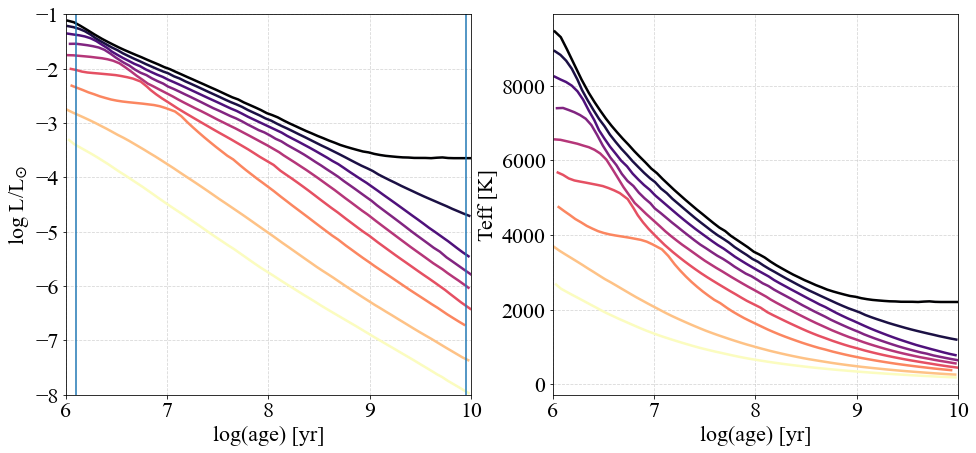

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

colors = bokeh.palettes.magma(len(M))
colors = colors[::-1] # reverse tuple

i = 0
for mass in M:
    ax[0].plot(age[mass], logL[mass], color=colors[i], lw=2.5)
    ax[1].plot(age[mass], Teff[mass], color=colors[i], lw=2.5)
    i = i+1

ax[0].set_ylabel("log L/L$_{\odot}$")
ax[0].set_xlabel("log(age) [yr]")
ax[0].grid(which="both", ls="--", alpha=0.5)
ax[0].set_ylim([-8, -1])
ax[0].set_xlim([6, 10])
ax[0].axvline(6.1)
ax[0].axvline(9.95)

ax[1].set_ylabel("Teff [K]")
ax[1].set_xlabel("log(age) [yr]")
ax[1].grid(which="both", ls="--", alpha=0.5)
ax[1].set_xlim([6, 10])

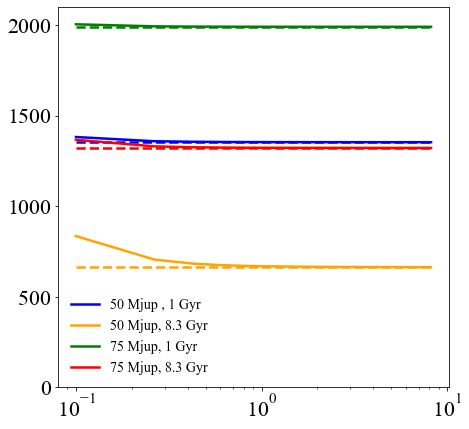

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

r = np.linspace(0.1, 8.178, 50)
m = 50.*M_jup; l_age = 9.
h_int = heat(Teff_interp_2d(l_age, m/M_sun), R_jup.value)
t = temperature_withDM(r, h_int, f=1, R=R_jup.value, M=m, parameters=[1, 20, 0.42])
ax.plot(r, t, label="50 Mjup , 1 Gyr", lw=2.5, color="blue")
ax.plot(r, np.ones(len(r))*Teff_interp_2d(l_age, m/M_sun), ls="--", lw=2.5, color="blue")

m = 50.*M_jup; l_age = 9.92
h_int = heat(Teff_interp_2d(l_age, m/M_sun), R_jup.value)
t = temperature_withDM(r, h_int, f=1, R=R_jup.value, M=m, parameters=[1, 20, 0.42])
ax.plot(r, t, label="50 Mjup, 8.3 Gyr", lw=2.5, color="orange")
ax.plot(r, np.ones(len(r))*Teff_interp_2d(l_age, m/M_sun), ls="--", lw=2.5, color="orange")

m = 75.*M_jup; l_age = 9.
h_int = heat(Teff_interp_2d(l_age, m/M_sun), R_jup.value)
t = temperature_withDM(r, h_int, f=1, R=R_jup.value, M=m, parameters=[1, 20, 0.42])
ax.plot(r, t, label="75 Mjup, 1 Gyr", lw=2.5, color="green")
ax.plot(r, np.ones(len(r))*Teff_interp_2d(l_age, m/M_sun), ls="--", lw=2.5, color="green")

m = 75.*M_jup; l_age = 9.92
h_int = heat(Teff_interp_2d(l_age, m/M_sun), R_jup.value)
t = temperature_withDM(r, h_int, f=1, R=R_jup.value, M=m, parameters=[1, 20, 0.42])
ax.plot(r, t, label="75 Mjup, 8.3 Gyr", lw=2.5, color="red")
ax.plot(r, np.ones(len(r))*Teff_interp_2d(l_age, m/M_sun), ls="--", lw=2.5, color="red")

ax.legend(frameon=False, fontsize=14)
ax.set_ylim([0, 2100])
ax.set_xscale("log")

### ATMO 2020

In [6]:
path   = "../data/evolution_models/ATMO_2020_models/evolutionary_tracks/"
models = ["ATMO_CEQ/", "ATMO_NEQ_strong/", "ATMO_NEQ_weak/"]

evolution_ATMO20      = {}
evolution_ATMO20["M"] = []
for model in models:
    evolution_ATMO20[model] = {}
    files = glob.glob(path + model + "*.txt")
    for file in files:
        data = np.genfromtxt(file, unpack=True)
        evolution_ATMO20[model][data[0][0]] = [data[1], data[2], data[3], data[4], data[5]] 
        # age [Gyr] / Teff [K] / L [L/Lsun] / R [R/Rjup] / log g [cm/s2]
        if model==models[0]:
            #print (data[0][0], file)
            evolution_ATMO20["M"].append(data[0][0])

In [7]:
print (evolution_ATMO20["M"])
print (len(evolution_ATMO20["M"]))

[0.029, 0.023, 0.056, 0.067, 0.012, 0.05, 0.018, 0.024, 0.051, 0.015, 0.02, 0.0005, 0.052, 0.027, 0.058, 0.069, 0.016, 0.01, 0.063, 0.055, 0.011, 0.06, 0.064, 0.07, 0.065, 0.054, 0.021, 0.017, 0.062, 0.068, 0.059, 0.053, 0.026, 0.061, 0.03, 0.014, 0.025, 0.019, 0.066, 0.04, 0.013, 0.022, 0.057, 0.028, 0.074, 0.001, 0.045, 0.073, 0.006, 0.048, 0.037, 0.042, 0.005, 0.041, 0.034, 0.008, 0.002, 0.046, 0.033, 0.039, 0.038, 0.047, 0.032, 0.003, 0.009, 0.035, 0.004, 0.071, 0.036, 0.043, 0.049, 0.072, 0.007, 0.031, 0.044, 0.075]
76


Text(0, 0.5, 'T$_{\\rm eff}$ [K]')

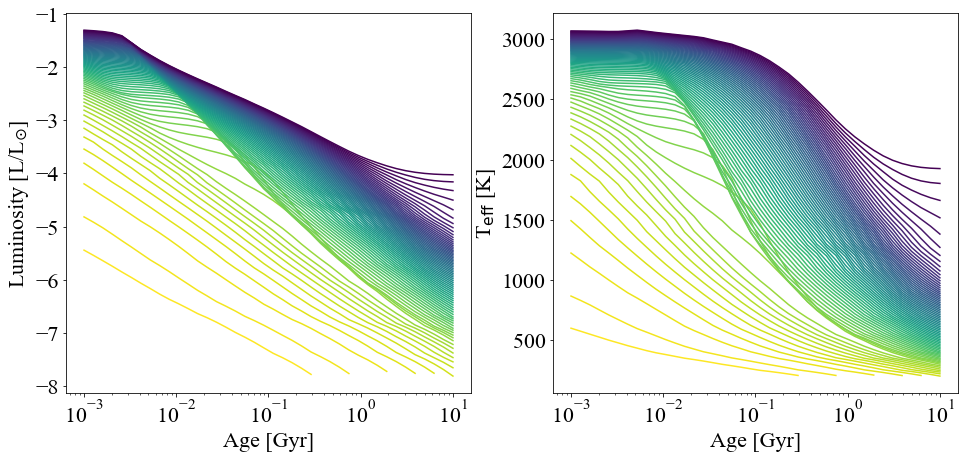

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

i     = 0
ls    = ["-", "--", ":"]
color = bokeh.palettes.viridis(len(evolution_ATMO20["M"]))
color = color[::-1]

models = ["ATMO_CEQ/"]#, "ATMO_NEQ_strong/", "ATMO_NEQ_weak/"]
masses = np.sort(np.asarray(evolution_ATMO20["M"]))

for model in models:
    j = 0
    for mass in masses:
        #if (np.abs(mass-0.06) < 0.009) or (np.abs(mass-0.07) < 0.009):
        #    print(mass)
        #    continue
        ax[0].plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][2], ls=ls[i], color=color[j])
        ax[1].plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][1], ls=ls[i], color=color[j])
        j = j+1
    i = i+1
        
ax[0].set_xlabel("Age [Gyr]")
ax[0].set_xscale("log")
ax[0].set_ylabel(r"Luminosity [L/L$_{\odot}$]")
ax[1].set_xlabel("Age [Gyr]")
ax[1].set_xscale("log")
ax[1].set_ylabel(r"T$_{\rm eff}$ [K]")

Text(0, 0.5, 'Radius [Rsun]')

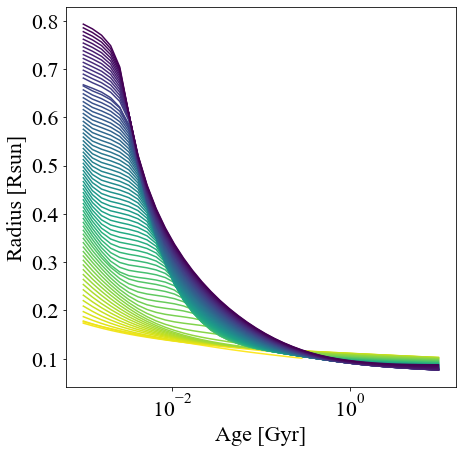

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

i     = 0
ls    = ["-", "--", ":"]
color = bokeh.palettes.viridis(len(evolution_ATMO20["M"]))
color = color[::-1]

models = ["ATMO_CEQ/"]#, "ATMO_NEQ_strong/", "ATMO_NEQ_weak/"]
masses = np.sort(np.asarray(evolution_ATMO20["M"]))

for model in models:
    j = 0
    for mass in masses:
        #if (np.abs(mass-0.06) < 0.009) or (np.abs(mass-0.07) < 0.009):
        #    print(mass)
        #    continue
        ax.plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][3], ls=ls[i], color=color[j])
        j = j+1
    i = i+1
        
ax.set_xlabel("Age [Gyr]")
ax.set_xscale("log")
ax.set_ylabel(r"Radius [Rsun]") # CHANGE

Text(0, 0.5, 'T$_{\\rm eff}$ [K]')

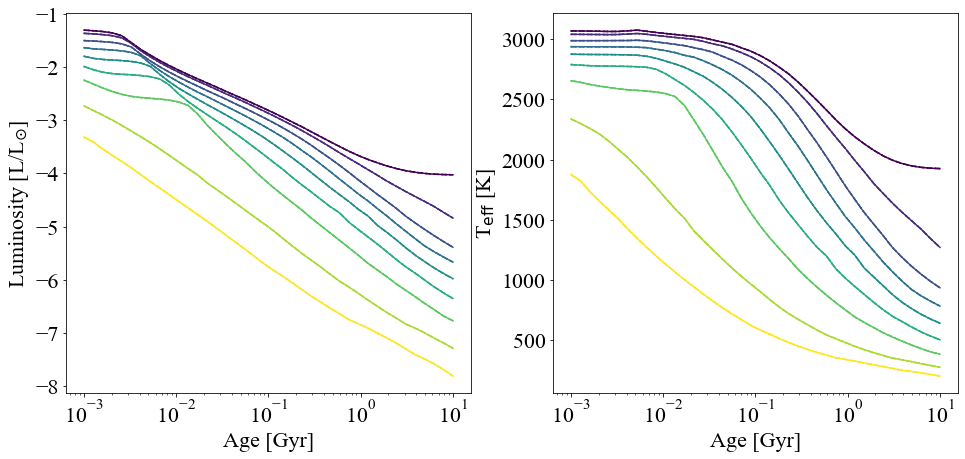

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

i     = 0
ls    = ["-", "--", ":"]



models = ["ATMO_CEQ/", "ATMO_NEQ_strong/", "ATMO_NEQ_weak/"]
masses = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.075]
color  = bokeh.palettes.viridis(len(masses))
color  = color[::-1]

for model in models:
    j = 0
    for mass in masses:
        #if (np.abs(mass-0.06) < 0.009) or (np.abs(mass-0.07) < 0.009):
        #    print(mass)
        #    continue
        ax[0].plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][2], ls=ls[i], color=color[j])
        ax[1].plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][1], ls=ls[i], color=color[j])
        j = j+1
    i = i+1
        
ax[0].set_xlabel("Age [Gyr]")
ax[0].set_xscale("log")
ax[0].set_ylabel(r"Luminosity [L/L$_{\odot}$]")
ax[1].set_xlabel("Age [Gyr]")
ax[1].set_xscale("log")
ax[1].set_ylabel(r"T$_{\rm eff}$ [K]")

**L <--> Teff mapping**

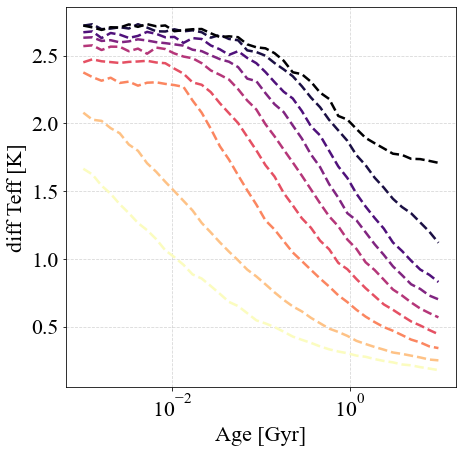

In [141]:
models = ["ATMO_CEQ/"]#, "ATMO_NEQ_strong/", "ATMO_NEQ_weak/"]
masses = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.075]
T      = {}
colors = bokeh.palettes.magma(len(M))
colors = colors[::-1]

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

for model in models:
    i = 0
    for mass in masses:
        T[mass] = temperature(10**evolution_ATMO20[model][mass][2]*L_sun.value, evolution_ATMO20[model][mass][3]*R_sun.value)
        ax.plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][1]-T[mass].value, color=colors[i], lw=2.5, ls="--")
        #ax.plot(evolution_ATMO20[model][mass][0], T[mass], color=colors[i], lw=2.5, ls="--")
        i = i+1
        
ax.set_ylabel("diff Teff [K]")
ax.set_xlabel("Age [Gyr]")
ax.grid(which="both", ls="--", alpha=0.5)
#ax.set_ylim([0, 8000])
ax.set_xscale("log")

### All

dict_keys([0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08])


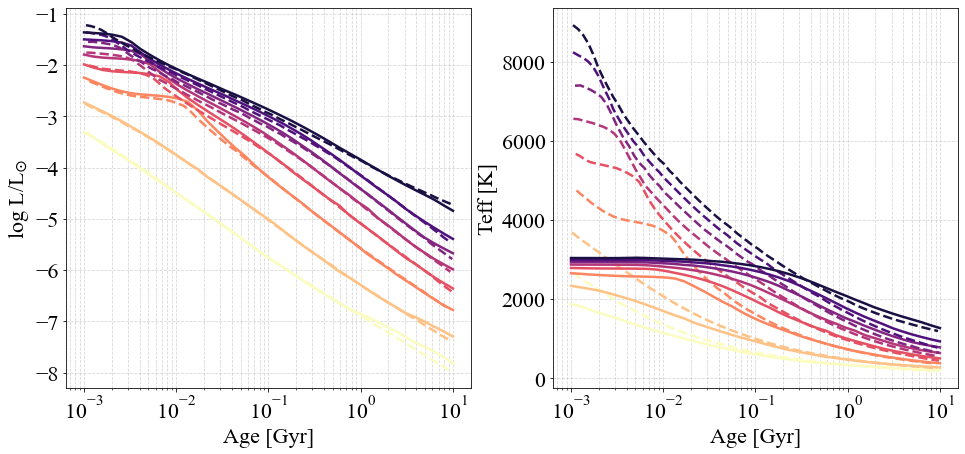

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))


M = evolution_SM08.keys()
print(M)

colors = bokeh.palettes.magma(len(M))
colors = colors[::-1] # reverse tuple
model  = "ATMO_CEQ/"

i = 0
for mass in M:
    if np.abs(mass-0.08) < 0.001:
        continue
    ax[0].plot(evolution_SM08[mass][0]/1e9, evolution_SM08[mass][2], color=colors[i], lw=2.5, ls="--")
    ax[1].plot(evolution_SM08[mass][0]/1e9, evolution_SM08[mass][1], color=colors[i], lw=2.5, ls="--")
    try:
        ax[0].plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][2], color=colors[i], lw=2.5, ls="-")
        ax[1].plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][1], color=colors[i], lw=2.5, ls="-")
    except:
        print(mass)
    i = i+1

ax[0].set_ylabel(r"log L/L$_{\odot}$")
ax[0].set_xlabel("Age [Gyr]")
ax[0].grid(which="both", ls="--", alpha=0.5)
ax[0].set_xscale("log")
#ax[0].set_ylim([-8, -1])
#ax[0].set_xlim([6, 10])

ax[1].set_ylabel("Teff [K]")
ax[1].set_xlabel("Age [Gyr]")
ax[1].grid(which="both", ls="--", alpha=0.5)
#ax[1].set_xlim([6, 10])
ax[1].set_xscale("log")

dict_keys([0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08])


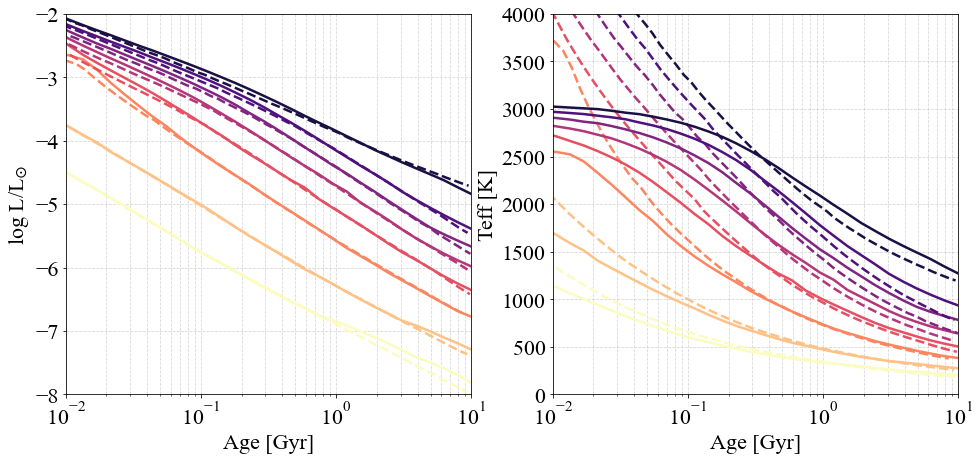

In [123]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))


M = evolution_SM08.keys()
print(M)

colors = bokeh.palettes.magma(len(M))
colors = colors[::-1] # reverse tuple
model  = "ATMO_CEQ/"

i = 0
for mass in M:
    if np.abs(mass-0.08) < 0.001:
        continue
    ax[0].plot(evolution_SM08[mass][0]/1e9, evolution_SM08[mass][2], color=colors[i], lw=2.5, ls="--")
    ax[1].plot(evolution_SM08[mass][0]/1e9, evolution_SM08[mass][1], color=colors[i], lw=2.5, ls="--")
    try:
        ax[1].plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][1], color=colors[i], lw=2.5, ls="-")
        ax[0].plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][2], color=colors[i], lw=2.5, ls="-")
    except:
        print(mass)
    i = i+1

ax[0].set_ylabel("log L/L$_{\odot}$")
ax[0].set_xlabel("Age [Gyr]")
ax[0].grid(which="both", ls="--", alpha=0.5)
ax[0].set_xscale("log")
ax[0].set_ylim([-8, -2.])
ax[0].set_xlim([0.01, 10])

ax[1].set_ylabel("Teff [K]")
ax[1].set_xlabel("Age [Gyr]")
ax[1].grid(which="both", ls="--", alpha=0.5)
ax[1].set_xlim([0.01, 10])
ax[1].set_ylim([0, 4000])
ax[1].set_xscale("log")